## Table of contents :
* [I - Preprocessing](#first)
    * [1 - Feature Selection](#first_1)
    * [2 - Split features & targets](#first_2)
    * [3 - Feature Scaling](#first_3)
* [II - Modelization](#second)
    * [1 - Find optimal cluster number with elbow method](#second_1)
    * [2 - Find optimal cluster number with silhouette score](#second_2)
    * [3 - Segmentation selection](#second_3)
      * [3.1 - First segmentation (k = 6)](#second_3_1)
      * [3.2 - Second segmentation (k = 11)](#second_3_2)
* [III - Results](#third)
    * [1 - Generalization](#third_1)
    * [2 - Feature importance](#third_2)
    * [3 - Segment analysis](#third_3)
* [IV - Conclusion](#fourth)

In [1]:
import sys
sys.path.append("..")
from utils.olist import *
from warnings import simplefilter
simplefilter(action='ignore', category='FutureWarning')
# Full length dataframe
pd.set_option('display.max_colwidth', None)
%matplotlib inline

/home/adil/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Import OLIST train data (built from EDA notebook)

# Read training data for each scaling type
df = pd.read_csv(f'../data/csv/olist_train_data.csv')
# Backup
df_backup = df.copy()
# Set customer id as index
df.set_index('customer_id', inplace=True)
# Get main RFM features
rfm_cols = ['recency', 'frequency', 'monetary_value']
# Re-ordered columns
reordered_cols = rfm_cols + [col for col in df.columns if col not in rfm_cols]
# Re-ordering columns
df = df[reordered_cols]
# Filter order purchase date feature
df = df.iloc[:, ~df.columns.isin(['order_purchase_date'])] 
# Display n rows (n = 2)
df.head(2)

,recency,frequency,monetary_value,total_products_purchased,total_sellers,main_order_purchase_month,main_order_purchase_day,average_price,average_freight_value,average_payment_value,segment
customer_id,,,,,,,,,,,
9ee5b1ab5aa40ce51e7a2cf4cd0eab65,5.135798,0.693147,5.558641,0.693147,0.693147,1.609438,2.944439,4.836203,4.901415,5.558641,Rising customers
cd0e52baedcb82662b0accd789d7f221,4.663439,0.693147,3.854394,0.693147,0.693147,1.945910,3.332205,3.363842,2.960105,3.854394,New customers


# I - Preprocessing <a class="anchor" id="first"></a>

## 1 - Feature Selection <a class="anchor" id="first_1"></a>

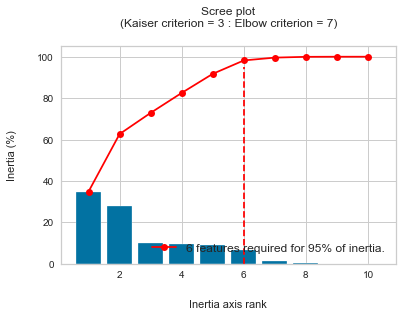

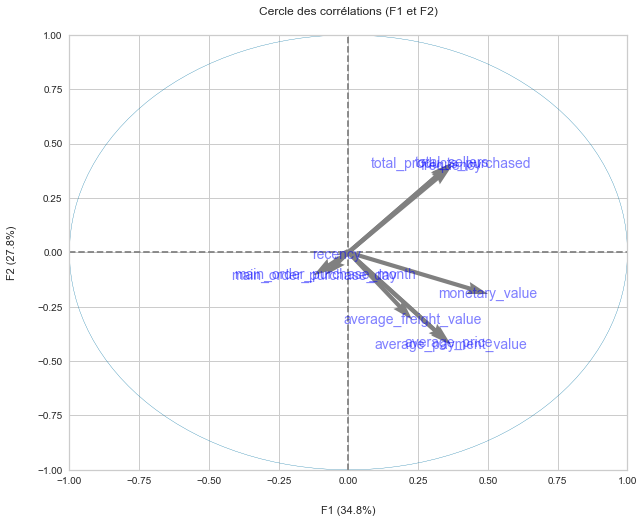

In [3]:
# Build PCA
pca_model = LinearPCA(df.iloc[:, :-1])
# Fit PCA
pca_model.fit()
# Visualize scree plot
pca_model.scree_plot(threshold=0.95)
# Visualize 1st factorial plan correlation circle
pca_model.plot_correlation_circle(n_plan=1, labels=pca_model.features)

## 2 - Split features & targets <a class="anchor" id="first_2"></a>

In [4]:
# Dissociate features & targets

# Create copy from modelization dataset
df_kmeans = df.copy()
# Define RFM segments as targets
df_targets = df_kmeans['segment']
# Serialize targets
target_data = pd.Series(df_targets.values, name='segment')
# Define training features by excluding RFM segments from main features
features = df_kmeans.loc[:, df_kmeans.columns != 'segment']

CPU times: user 2min 29s, sys: 804 ms, total: 2min 30s
Wall time: 50.4 s


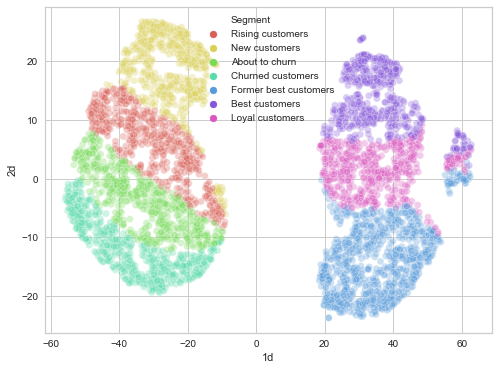

In [5]:
%%time

# Plot targets with t-SNE based on RFM features
plot_RFM_segments(features[rfm_cols],
                  target_data,
                  n_dim=2,
                  p=100,
                  tsne_init='pca',
                  v=False)

CPU times: user 1min 53s, sys: 315 ms, total: 1min 53s
Wall time: 33.4 s


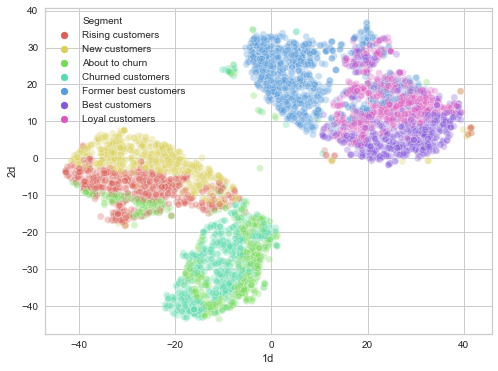

In [6]:
%%time

# Plot targets with t-SNE (all training features)
plot_RFM_segments(features,
                  target_data,
                  n_dim=2,
                  p=100,
                  tsne_init='pca',
                  v=False) ###

## 3 - Feature Scaling <a class="anchor" id="first_3"></a>

In [7]:
# Scale training features
features_std_scaled, std_scaler = standard_scaler(features,
                                                  return_std_scaler=True,
                                                  rebuild_df=True)

# II - Modelization : k-means <a class="anchor" id="second"></a>

## 1 - Find optimal cluster number with elbow method <a class="anchor" id="second_1"></a>

CPU times: user 1min 40s, sys: 20.5 s, total: 2min
Wall time: 31.4 s


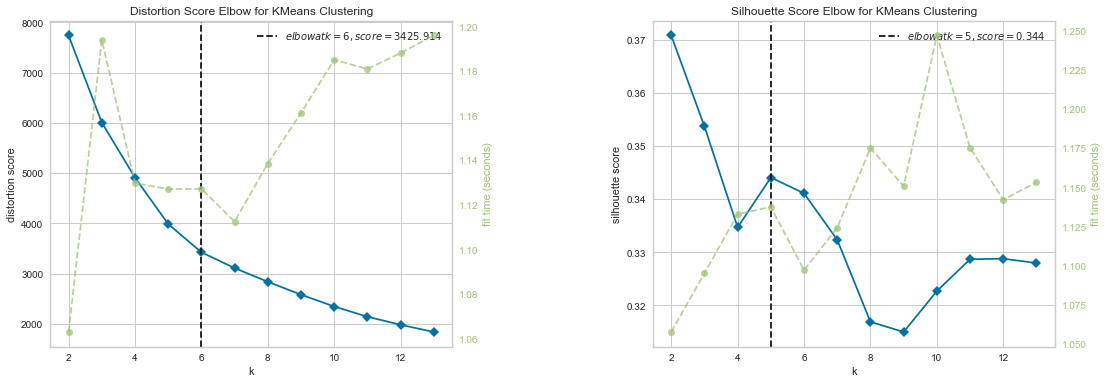

In [8]:
%%time

# Define baseline training subset with RFM features
features_std_scaled_rfm = features_std_scaled[rfm_cols].copy()

# Use elbow method to find optimal cluster number 

# Build subplots figure & axes
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
# Elbow method
Kmeans(features_std_scaled_rfm, k_range=(2, 14)).plot_kelbow_visualizer(axis=axes[0],
                                                                        plt_show=False)
# Silhouette method
Kmeans(features_std_scaled_rfm, k_range=(2, 14)).plot_kelbow_visualizer(scorer='silhouette',
                                                                        axis=axes[1],
                                                                        plt_show=False)
# fig.tight_layout()
fig.subplots_adjust(hspace=.65, wspace=.5)

## 2 - Find optimal cluster number with silhouette score <a class="anchor" id="second_2"></a>

In [9]:
%%time

# Find best model & feature set by training multiple k-means by adding features iteratively
# see: get_optimal_kmeans_feature_set function in olist module 
kmeans_results_df = get_optimal_kmeans_feature_set(features_std_scaled, k_range=(5, 16), verbose=True)
# Display best results from best Silhouette score
best_results = kmeans_results_df.nlargest(1, 'score')
best_results

  n    score  features                                      total_features
---  -------  ------------------------------------------  ----------------
  5     0.34  ['recency', 'frequency', 'monetary_value']                 3


  n    score  features                                                                  total_features
---  -------  ----------------------------------------------------------------------  ----------------
  6     0.34  ['recency', 'frequency', 'monetary_value', 'total_products_purchased']                 4


  n    score  features                                                                                   total_features
---  -------  ---------------------------------------------------------------------------------------  ----------------
  5     0.34  ['recency', 'frequency', 'monetary_value', 'total_products_purchased', 'total_sellers']                 5


  n    score  features                                                                              

,n,score,model,features,total_features
0,5,0.34,<src.clusterizer.kmeans.Kmeans object at 0x7f81d09b8310>,"[recency, frequency, monetary_value]",3


## 3 - Segmentation selection <a class="anchor" id="second_3"></a>

### 3.1 - First segmentation (k = 6) <a class="anchor" id="second_3_1"></a>

#### 3.1.1 - Evaluate cluster stability

In [10]:
%%time

# Initialization counter
n_init = 5

# Cluster stability evaluation list
cluster_stability_results_6k = []

# Train k-means n times
for n in range(n_init):
    kmeans_results_df = get_optimal_kmeans_feature_set(features_std_scaled, k_range=6, verbose=False)
    # Display best results from best Silhouette score
    best_results = kmeans_results_df.nlargest(1, 'score')
    # Append best results to cluster stability evaluation list
    cluster_stability_results_6k.append(best_results)

# Build cluster stability results dataframe from list
cluster_stability_results_df_6k = pd.concat(cluster_stability_results_6k)
# Display cluster stability results
cluster_stability_results_df_6k

CPU times: user 3min 22s, sys: 33.7 s, total: 3min 56s
Wall time: 1min 17s


,n,score,model,features,total_features
0,6,0.34,<src.clusterizer.kmeans.Kmeans object at 0x7f81d09a7950>,"[recency, frequency, monetary_value]",3
0,6,0.34,<src.clusterizer.kmeans.Kmeans object at 0x7f81d096fb50>,"[recency, frequency, monetary_value]",3
0,6,0.34,<src.clusterizer.kmeans.Kmeans object at 0x7f81d09b8cd0>,"[recency, frequency, monetary_value]",3
0,6,0.34,<src.clusterizer.kmeans.Kmeans object at 0x7f81d096b910>,"[recency, frequency, monetary_value]",3
0,6,0.34,<src.clusterizer.kmeans.Kmeans object at 0x7f81d09aff10>,"[recency, frequency, monetary_value]",3


#### 3.1.2 - Select best model

In [11]:
# Select best model from cluster stability results
kmeans_best_model_6k = cluster_stability_results_df_6k.model.iloc[0]
# Create segmentation copy from scaled training features
df_kmeans_6k_scaled = features_std_scaled.copy()
# Assign cluster labels
df_kmeans_6k_scaled['cluster'] = kmeans_best_model_6k.clusters + 1

#### 3.1.3 - Visualize segmentation

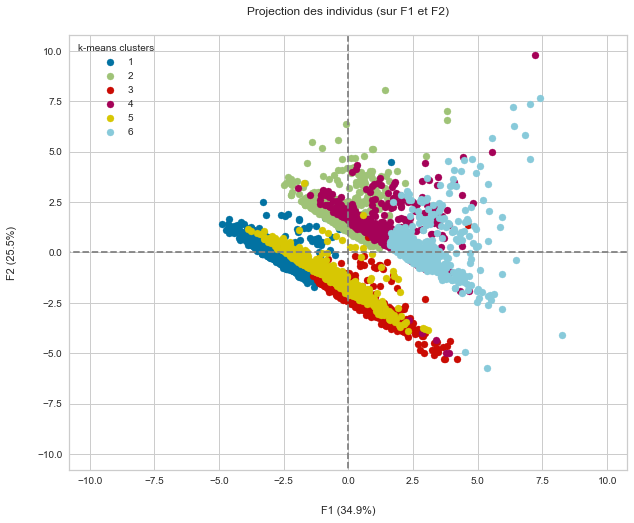

In [12]:
# PCA

pca_model_6k = LinearPCA(df_kmeans_6k_scaled)
pca_model_6k.fit()
pca_model_6k.plot_factorial_planes(n_plan=1,
                                   illustrative_var=df_kmeans_6k_scaled['cluster'],
                                   illustrative_var_title='k-means clusters')

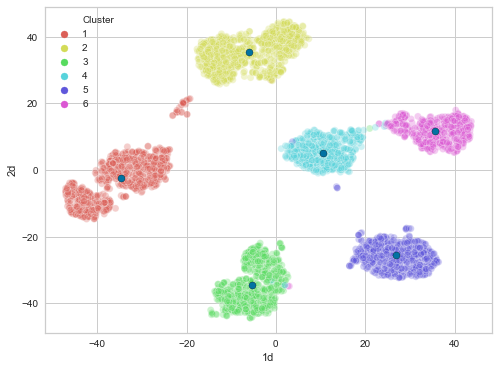

In [13]:
# t-SNE
cluster_data_6k = pd.Series(df_kmeans_6k_scaled.cluster.values, name='cluster')

tsne_6k = tSNE(df_kmeans_6k_scaled, n_comp=2, perplexity=100, init='pca', verbose=False)
tsne_6k.fit()
tsne_6k.plot(plot_size=(8, 6), cluster_labels=cluster_data_6k)

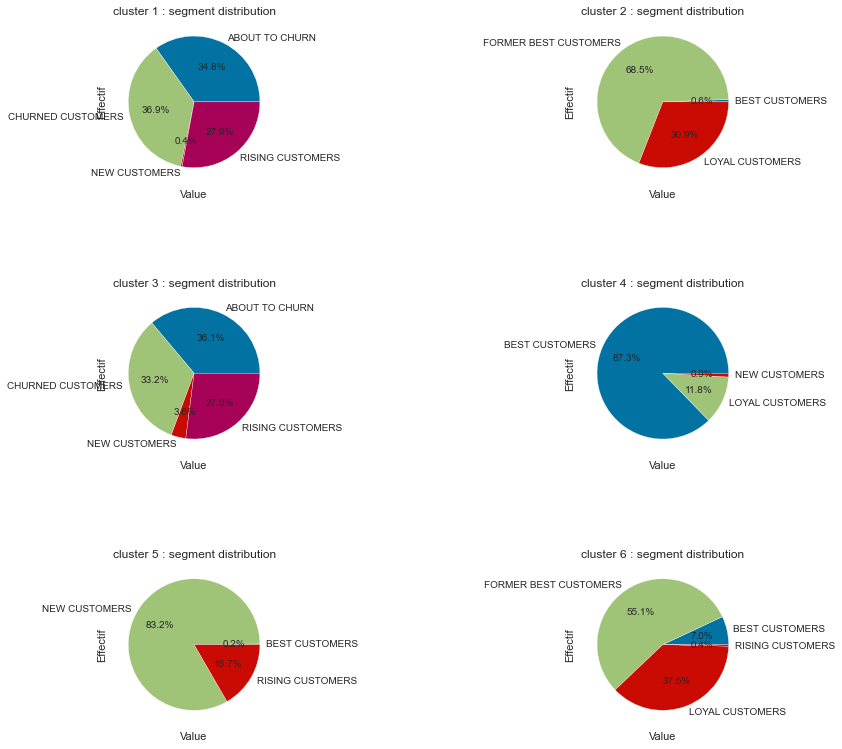

In [14]:
# Pie chart with original targets (RFM segmentation)

# Training data copy
df_kmeans_6k = features_std_scaled.copy()
# Reverse standard scaling 
df_kmeans_6k = reverse_standardization(df_kmeans_6k, std_scaler, rebuild_df=True)
# Import log scaler instance 
log_transformer = pickle_data('log_transformer', data=None, folder='../data/pkl', method='r')
# Reverse log scaling 
df_kmeans_6k = reverse_standardization(df_kmeans_6k, log_transformer, rebuild_df=True)
# Annotate data with cluster labels
df_kmeans_6k['clusters'] = kmeans_best_model_6k.clusters + 1
# Original modelization dataset copy
df_backup_6_segments = df_backup.copy()
# Annotate original modelization dataset copy with cluster labels
df_backup_6_segments['cluster'] = df_backup_6_segments.customer_id.map(dict(df_kmeans_6k['clusters']))
# Get pie chart subplots rows count based on k clusters
total_clusters_by_col_6_segments = (len(df_kmeans_6k['clusters'].unique()) // 2) + 1
# Plot pie chart subplots with RFM segments
plot_pie_subplots(df=df_backup_6_segments,
                  col='segment',
                  cats='cluster',
                  shape=(total_clusters_by_col_6_segments, 2))

#### 3.1.4 - Evaluate segmentation with centroids inspection

In [15]:
# Original dataset description
np.expm1(df.iloc[:, :-1]).describe()

,recency,frequency,monetary_value,total_products_purchased,total_sellers,main_order_purchase_month,main_order_purchase_day,average_price,average_freight_value,average_payment_value
count,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000
mean,264.939990,1.520413,202.297260,1.641417,1.592474,5.522135,14.069602,114.861735,20.023817,136.650006
std,145.465061,0.660390,234.598848,1.047364,0.891635,3.172239,8.499639,147.548861,14.019890,153.959921
min,44.000000,1.000000,17.220000,1.000000,1.000000,1.000000,1.000000,5.990000,0.130000,15.620000
25%,148.250000,1.000000,82.257500,1.000000,1.000000,3.000000,7.000000,45.712500,13.422500,62.507500
50%,243.000000,1.000000,143.475000,1.000000,1.000000,5.000000,14.000000,79.082500,16.600000,98.340000
75%,369.000000,2.000000,242.000000,2.000000,2.000000,8.000000,21.000000,134.337500,21.320833,158.130000
max,639.000000,14.000000,7571.630000,30.000000,23.000000,12.000000,31.000000,3694.000000,251.390000,3785.815000


In [16]:
# Centroids inspection
training_set_6k_centroids = df_kmeans_6k.groupby('clusters').mean().T
training_set_6k_centroids

clusters,1,2,3,4,5,6
recency,343.664720,335.034238,332.226879,102.736162,107.503268,286.110251
frequency,1.000000,2.047226,1.000000,2.107011,1.001634,2.214700
monetary_value,62.182033,149.027296,262.439971,244.041587,114.904101,500.747408
total_products_purchased,1.064252,2.226682,1.063584,2.245387,1.040850,2.489362
total_sellers,1.047897,2.162928,1.034682,2.191882,1.026144,2.348162
main_order_purchase_month,5.974299,5.178276,6.008671,4.804428,6.186275,4.651838
main_order_purchase_day,16.037383,12.876033,15.939306,10.822878,15.566993,11.895551
average_price,46.773890,56.923872,232.235882,100.226317,92.523562,207.196383
average_freight_value,15.021881,15.465966,27.356156,19.473627,21.181912,25.164293
average_payment_value,62.182033,73.455671,262.439971,121.275858,114.874739,237.003553


<AxesSubplot:>

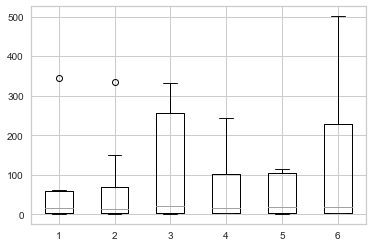

In [17]:
# Boxplot
df_kmeans_6k.groupby('clusters').mean().T.boxplot()

#### 3.1.5 - Segmentation overview (k = 6)

In [18]:
# Build segmentation based on centroids inspection

segments_data_6k = {
    
"1 - Cheap Customers Lost": ["low",                  # Lost customers who :
                             "summer",               # did not return often,
                             "mid-month",            # did not spend a lot
                             "very low",
                             "very low",
                             "very low"],
    
"2 - Promising Customers Lost": ["high",             # Lost customers who :
                                 "spring",           # returned often,
                                 "beginning",        # and did not spend a lot
                                 "low",
                                 "low",
                                 "low"],
    
"3 - Impulse Customers Lost": ["low",                # Lost customers who :
                               "summer",             # did not return often,
                               "mid-month",          # spend a lot
                               "very high",
                               "very high",
                               "very high"],
    
"4 - Promising New Customers": ["high",              # New highly engaged customers who have bought :
                                "spring",            # recently,
                                "beginning",         # often,
                                "high",              # and spend a lot
                                "high",
                                "high"],  
"5 - New Customers": ["low",                         # New customers
                      "summer",              
                      "mid-month",
                      "high",
                      "high",
                      "high"],
    
"6 - Best Customers": ["high",                       # Highly engaged customers who have bought :
                       "spring",                     # the most recent,
                       "beginning",                  # the most often,
                       "very high",                  # and generated the most revenue.
                       "very high",
                       "very high"]
}

# Build segmentation results dataframe 
df_6_segments = pd.DataFrame(segments_data_6k,
                             index=['Order frequency',
                                    'Season',
                                    'Month period',
                                    'Average price',
                                    'Average freight',
                                    'Average payment']).T

# Build segmentation results colored dataframe 
df_6_segments_colored = df_6_segments.style.apply(highlight_segments, axis=None)
# Display segmentation results colored dataframe 
df_6_segments_colored

,Order frequency,Season,Month period,Average price,Average freight,Average payment
1 - Cheap Customers Lost,low,summer,mid-month,very low,very low,very low
2 - Promising Customers Lost,high,spring,beginning,low,low,low
3 - Impulse Customers Lost,low,summer,mid-month,very high,very high,very high
4 - Promising New Customers,high,spring,beginning,high,high,high
5 - New Customers,low,summer,mid-month,high,high,high
6 - Best Customers,high,spring,beginning,very high,very high,very high


**N.B :**

- We notice that **customers with high added value** make their purchases most often **in the spring** and **at the beginning of the month** (on average)

- Conversely **customers with low added value** shop most often during **the summer** and **in the middle of the month** (on average)
   - (with the exception of one segment which concerns **new customers**)

#### 3.1.6 - Segmentation update

In [19]:
# Get order purchase date from backup data

df_backup_6_segments.set_index('customer_id', inplace=True)
df_backup_6_segments_order_purchase_date = dict(df_backup_6_segments.order_purchase_date)
df_kmeans_6k['order_purchase_date'] = df_backup_6_segments.index.map(df_backup_6_segments_order_purchase_date)

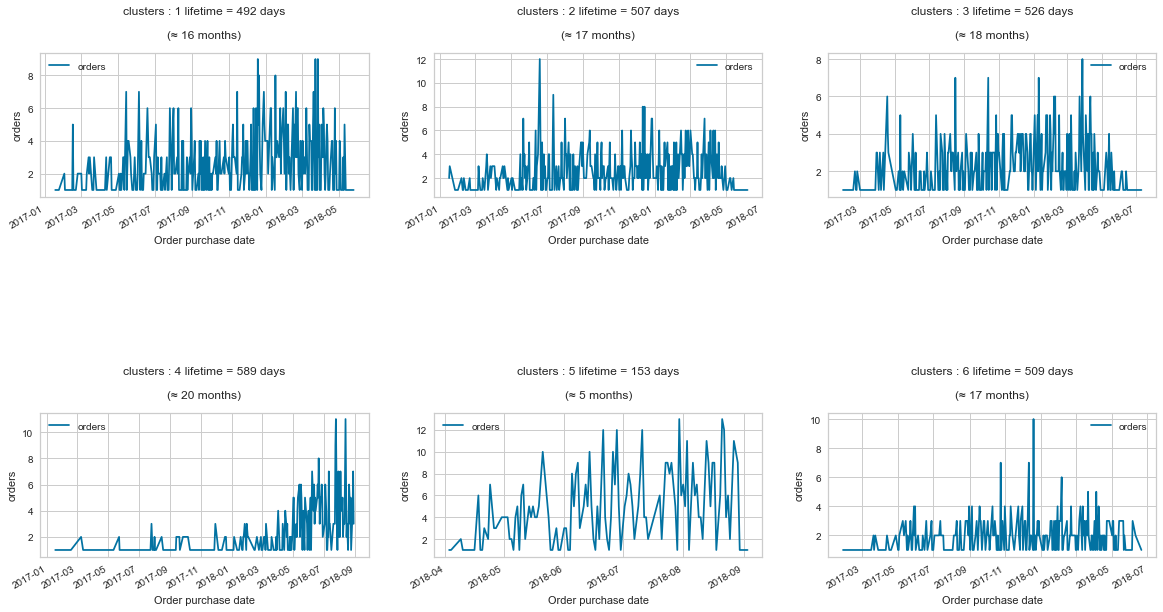

In [20]:
# Plot segment lifetime 

df_ts_6k = plot_time_serie_subplots(df=df_kmeans_6k,
                                    col='order_purchase_date',
                                    cats='clusters',
                                    shape=(total_clusters_by_col_6_segments, 3),
                                    fig_size=(20, 25),
                                    xlabel='order_purchase_date'.replace('_', ' ').capitalize(),
                                    ylabel='orders',
                                    return_data=True)

In [21]:
# Display segment lifetime data

# Build segmentation maintenance data
df_ts_6k_lifetime_reindexed = df_ts_6k[['clusters', 'lifetime']].drop_duplicates().set_index('clusters')
segmentation_6k_update = np.round(df_ts_6k_lifetime_reindexed / 30).astype(int)
segmentation_6k_update.rename(columns={'lifetime': 'Lifetime (months)'}, inplace=True)
segmentation_6k_update.index.rename('Segments', inplace=True)
segmentation_6k_update.index = df_6_segments_colored.index
segmentation_6k_update.T

,1 - Cheap Customers Lost,2 - Promising Customers Lost,3 - Impulse Customers Lost,4 - Promising New Customers,5 - New Customers,6 - Best Customers
Lifetime (months),16,17,18,20,5,17


In [22]:
# Segments in red must be updated first, unlike those in green
segmentation_6k_update_colored = segmentation_6k_update.style.apply(highlight_segment_update, axis=None)
segmentation_6k_update_colored

,Lifetime (months)
1 - Cheap Customers Lost,16
2 - Promising Customers Lost,17
3 - Impulse Customers Lost,18
4 - Promising New Customers,20
5 - New Customers,5
6 - Best Customers,17


In [23]:
# Save model as pkl
pickle_data(filename='Multiple_orders_kmeans_6k',
            data=kmeans_best_model_6k,
            folder='../data/pkl',
            method='w')

### 3.2 - Second segmentation (k = 11) <a class="anchor" id="second_3_2"></a>

#### 3.2.1 - Evaluate cluster stability

In [24]:
%%time

# Best segmentation feature selection
best_features_11k = ['recency',
                     'frequency',
                     'monetary_value',
                     'total_products_purchased',
                     'total_sellers',
                     'main_order_purchase_month',
                     'average_payment_value']

# Cluster stability evaluation list
cluster_stability_results_11k = []

# Train k-means n times
for n in range(n_init):
    kmeans_results_df = get_optimal_kmeans_from_k_range(features_std_scaled[best_features_11k],
                                                        cluster_range=11,
                                                        n_best_scores=1)
    # Display best results from best Silhouette score
    best_results = kmeans_results_df['best_results'].nlargest(1, 'score')
    # Append best results to cluster stability evaluation list
    cluster_stability_results_11k.append(best_results)
    
# Build cluster stability results dataframe from list    
cluster_stability_results_df_11k = pd.concat(cluster_stability_results_11k)
# Display cluster stability results
cluster_stability_results_df_11k

CPU times: user 24.5 s, sys: 4.38 s, total: 28.9 s
Wall time: 8.11 s


,n,score,model,features,total_features
0,11,0.3,<src.clusterizer.kmeans.Kmeans object at 0x7f81d0071890>,"[recency, frequency, monetary_value, total_products_purchased, total_sellers, main_order_purchase_month, average_payment_value]",7
0,11,0.3,<src.clusterizer.kmeans.Kmeans object at 0x7f81d09c05d0>,"[recency, frequency, monetary_value, total_products_purchased, total_sellers, main_order_purchase_month, average_payment_value]",7
0,11,0.3,<src.clusterizer.kmeans.Kmeans object at 0x7f81d09c0f10>,"[recency, frequency, monetary_value, total_products_purchased, total_sellers, main_order_purchase_month, average_payment_value]",7
0,11,0.3,<src.clusterizer.kmeans.Kmeans object at 0x7f81d0071450>,"[recency, frequency, monetary_value, total_products_purchased, total_sellers, main_order_purchase_month, average_payment_value]",7
0,11,0.3,<src.clusterizer.kmeans.Kmeans object at 0x7f81cb27c650>,"[recency, frequency, monetary_value, total_products_purchased, total_sellers, main_order_purchase_month, average_payment_value]",7


#### 3.2.2 - Select best model

In [25]:
kmeans_best_model_11k = cluster_stability_results_df_11k.model.iloc[0]
df_kmeans_11k_scaled = features_std_scaled.copy()
df_kmeans_11k_scaled['cluster'] = kmeans_best_model_11k.clusters + 1

#### 3.2.3 - Visualize segmentation

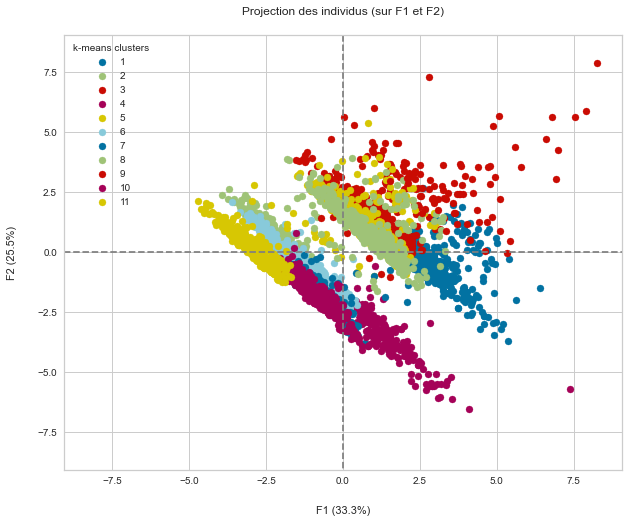

In [26]:
# PCA
pca_model_11k = LinearPCA(df_kmeans_11k_scaled)
pca_model_11k.fit()
pca_model_11k.plot_factorial_planes(n_plan=1,
                                    illustrative_var=df_kmeans_11k_scaled['cluster'],
                                    illustrative_var_title='k-means clusters')

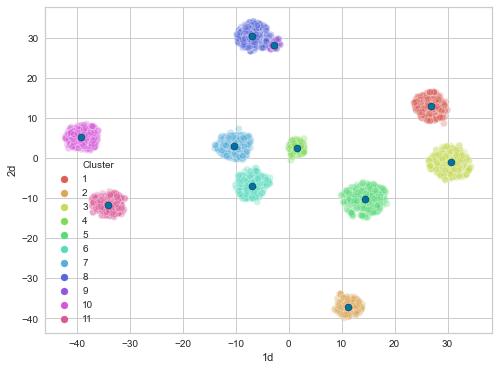

In [27]:
# t-SNE
cluster_data_11k = pd.Series(df_kmeans_11k_scaled.cluster.values, name='cluster')

tsne_11k = tSNE(df_kmeans_11k_scaled, n_comp=2, perplexity=200, init='pca', verbose=False)
tsne_11k.fit()
tsne_11k.plot(plot_size=(8, 6), cluster_labels=cluster_data_11k)

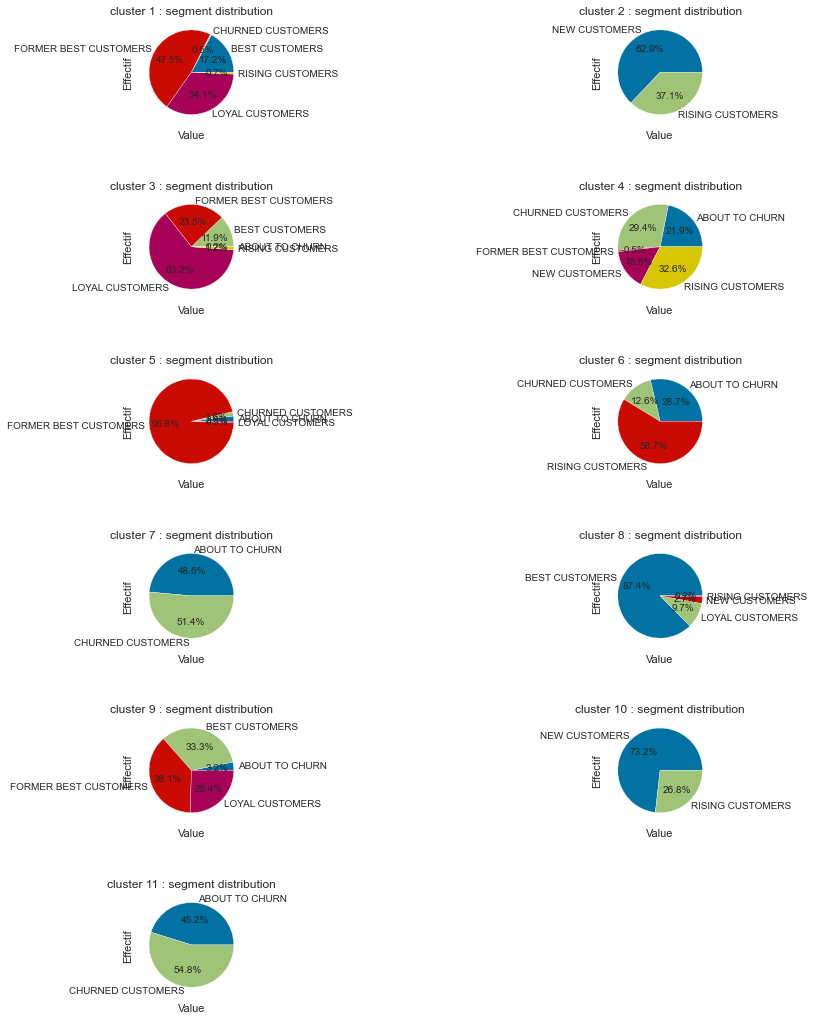

In [28]:
# Pie chart with original targets (RFM segmentation)

# Training data copy
df_kmeans_11k = features_std_scaled.copy()
# Reverse standard scaling 
df_kmeans_11k = reverse_standardization(df_kmeans_11k, std_scaler, rebuild_df=True)
# Reverse log scaling 
df_kmeans_11k = reverse_standardization(df_kmeans_11k, log_transformer, rebuild_df=True)
# Annotate data with cluster labels
df_kmeans_11k['clusters'] = kmeans_best_model_11k.clusters + 1
# Original modelization dataset copy
df_backup_11_segments = df_backup.copy()
# Annotate original modelization dataset copy with cluster labels
df_backup_11_segments['cluster'] = df_backup_11_segments.customer_id.map(dict(df_kmeans_11k['clusters']))
# Get pie chart subplots rows count based on k clusters
total_clusters_by_col_11_segments = (len(df_kmeans_11k['clusters'].unique()) // 2) + 1
# Plot pie chart subplots with RFM segments
plot_pie_subplots(df=df_backup_11_segments,
                  col='segment',
                  cats='cluster',
                  shape=(total_clusters_by_col_11_segments, 2))

#### 3.2.4 - Evaluate segmentation with centroids inspection

In [29]:
# Original dataset description
np.expm1(df.iloc[:, :-1]).describe()

,recency,frequency,monetary_value,total_products_purchased,total_sellers,main_order_purchase_month,main_order_purchase_day,average_price,average_freight_value,average_payment_value
count,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000
mean,264.939990,1.520413,202.297260,1.641417,1.592474,5.522135,14.069602,114.861735,20.023817,136.650006
std,145.465061,0.660390,234.598848,1.047364,0.891635,3.172239,8.499639,147.548861,14.019890,153.959921
min,44.000000,1.000000,17.220000,1.000000,1.000000,1.000000,1.000000,5.990000,0.130000,15.620000
25%,148.250000,1.000000,82.257500,1.000000,1.000000,3.000000,7.000000,45.712500,13.422500,62.507500
50%,243.000000,1.000000,143.475000,1.000000,1.000000,5.000000,14.000000,79.082500,16.600000,98.340000
75%,369.000000,2.000000,242.000000,2.000000,2.000000,8.000000,21.000000,134.337500,21.320833,158.130000
max,639.000000,14.000000,7571.630000,30.000000,23.000000,12.000000,31.000000,3694.000000,251.390000,3785.815000


In [30]:
# Centroids inspection
training_set_11k_centroids = df_kmeans_11k.groupby('clusters').mean().T
# Median version
training_set_11k_medians = df_kmeans_11k.groupby('clusters').median().T
# Display centroids for each features
training_set_11k_centroids

clusters,1,2,3,4,5,6,7,8,9,10,11
recency,271.097852,128.103343,229.254473,304.598930,390.093407,278.202564,395.433333,99.603865,249.968254,117.647643,401.191327
frequency,2.069212,1.000000,2.057654,1.005348,1.998168,1.000000,1.000000,2.021739,3.650794,1.000000,1.000000
monetary_value,527.195537,49.535775,162.870656,588.724920,168.201410,95.647590,159.833714,204.174589,432.755873,159.231266,53.826964
total_products_purchased,2.200477,1.021277,2.186879,1.048128,2.172161,1.020513,1.028571,2.135266,6.460317,1.019851,1.025510
total_sellers,2.124105,1.015198,2.143141,1.010695,2.089744,1.002564,1.007143,2.101449,5.682540,1.000000,1.015306
main_order_purchase_month,4.324582,5.541033,1.998012,5.187166,7.772894,1.887179,8.564286,5.500000,5.206349,5.836228,8.441327
main_order_purchase_day,11.453461,15.237082,12.270378,13.909091,13.525641,15.789744,17.095238,10.874396,11.730159,15.513648,16.341837
average_price,224.076221,34.886353,63.067210,522.832460,66.368233,77.395462,136.017262,82.065225,94.376381,132.522779,39.014949
average_freight_value,27.008958,14.452462,15.932333,40.014305,16.311490,17.471179,22.203190,18.855632,19.924158,24.872531,14.587577
average_payment_value,255.623484,49.535775,79.852797,568.479920,84.488724,95.647590,159.833714,101.659275,124.172064,159.231266,53.826964


<AxesSubplot:>

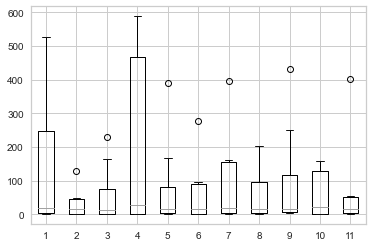

In [31]:
# Boxplot
df_kmeans_11k.groupby('clusters').mean().T.boxplot()

#### 3.2.5 - Segmentation overview (k = 11)

In [32]:
# Build segmentation data

segments_data_11k = {
    
"1 - Best Customers": ["high",                        # Highly engaged customers who have bought :
                       "spring",                      # the most recent,
                       "beginning",                   # the most often,
                       "very high",                   # and generated the most revenue
                       "very high",
                       "very high"],
    
"2 - Cheap New Customers": ["low",                    # New customers who :
                            "spring",                 # did not return often,
                            "mid-month",              # did not spend a lot
                            "very low",         
                            "very low",
                            "very low"],

"3 - Promising Customers": ["high",                   # Customers who :
                            "winter",                 # returned often,
                            "beginning",              # did not spend a lot
                            "low",
                            "medium",
                            "low"],
    
"4 - Highest Paying Customers": ["low",               # Customers who have generated the most revenue for Olist
                                 "spring",
                                 "beginning",
                                 "very high",
                                 "very high",
                                 "very high"],
  
"5 - Promising Customers Lost": ["high",              # Lost customers who :
                                 "summer",            # returned often,
                                 "beginning",         # did not spend a lot
                                 "low",
                                 "low",
                                 "low"],
    
"6 - Cheap Customers": ["low",                        # Slightly engaged customers who :
                        "winter",                     # did not return often,
                        "mid-month",                  # did not spend a lot
                        "low",                    
                        "high",
                        "low"],
    
"7 - Impulse Customers Lost": ["low",                 # Lost customers who :
                               "summer",              # did not return often,
                               "mid-month",           # spend a lot
                               "high",
                               "high",
                               "high"],
    
"8 - Best New Customers": ["high",                    # New highly engaged customers who have bought :
                           "spring",                  # recently,
                           "beginning",               # often,
                           "high",                    # and spend a lot
                           "high",
                           "high"],
    
"9 - Loyal Customers": ["very high",                  # Customers who buy the most often from Olist
                        "spring",
                        "beginning",
                        "high",
                        "high",
                        "high"],
    
"10 - Impulse New Customers": ["low",                 # Customers that do not have a specific product in mind
                               "spring",              # and purchase goods when it seems good at the time
                               "mid-month",
                               "high",
                               "high",
                               "high"],
    
"11 - Cheap Customers Lost": ["low",                  # Lost customers who :
                              "summer",               # did not return often,
                              "mid-month",            # did not spend a lot
                              "very low",
                              "very low",
                              "very low"] 
}

df_11_segments = pd.DataFrame(segments_data_11k,
                              index=['Order frequency',
                                     'Season',
                                     'Month period',
                                     'Average price',
                                     'Average freight',
                                     'Average payment']).T

df_11_segments_colored = df_11_segments.style.apply(highlight_segments, axis=None)
df_11_segments_colored

,Order frequency,Season,Month period,Average price,Average freight,Average payment
1 - Best Customers,high,spring,beginning,very high,very high,very high
2 - Cheap New Customers,low,spring,mid-month,very low,very low,very low
3 - Promising Customers,high,winter,beginning,low,medium,low
4 - Highest Paying Customers,low,spring,beginning,very high,very high,very high
5 - Promising Customers Lost,high,summer,beginning,low,low,low
6 - Cheap Customers,low,winter,mid-month,low,high,low
7 - Impulse Customers Lost,low,summer,mid-month,high,high,high
8 - Best New Customers,high,spring,beginning,high,high,high
9 - Loyal Customers,very high,spring,beginning,high,high,high
10 - Impulse New Customers,low,spring,mid-month,high,high,high


**N.B :**
- **Seasonality**
    - **Spring** seems to characterize **customers with high added value** _(excepted concerning cheap new customers)_
    - **Summer** seems to characterize **customers with low added value** _(excepted concerning promising customers lost)_


- **Temporality**
  - **Customers with high added value** make their purchases on average **at the beginning of the month**
  - **Customers with low added value** make their purchases on average **in the middle of the month**

#### 3.2.6 - Segmentation update

In [33]:
# Get order purchase date from backup data

df_backup_11_segments.set_index('customer_id', inplace=True)
df_backup_11_segments_order_purchase_date = dict(df_backup_11_segments.order_purchase_date)
df_kmeans_11k['order_purchase_date'] = df_backup_11_segments.index.map(df_backup_11_segments_order_purchase_date)

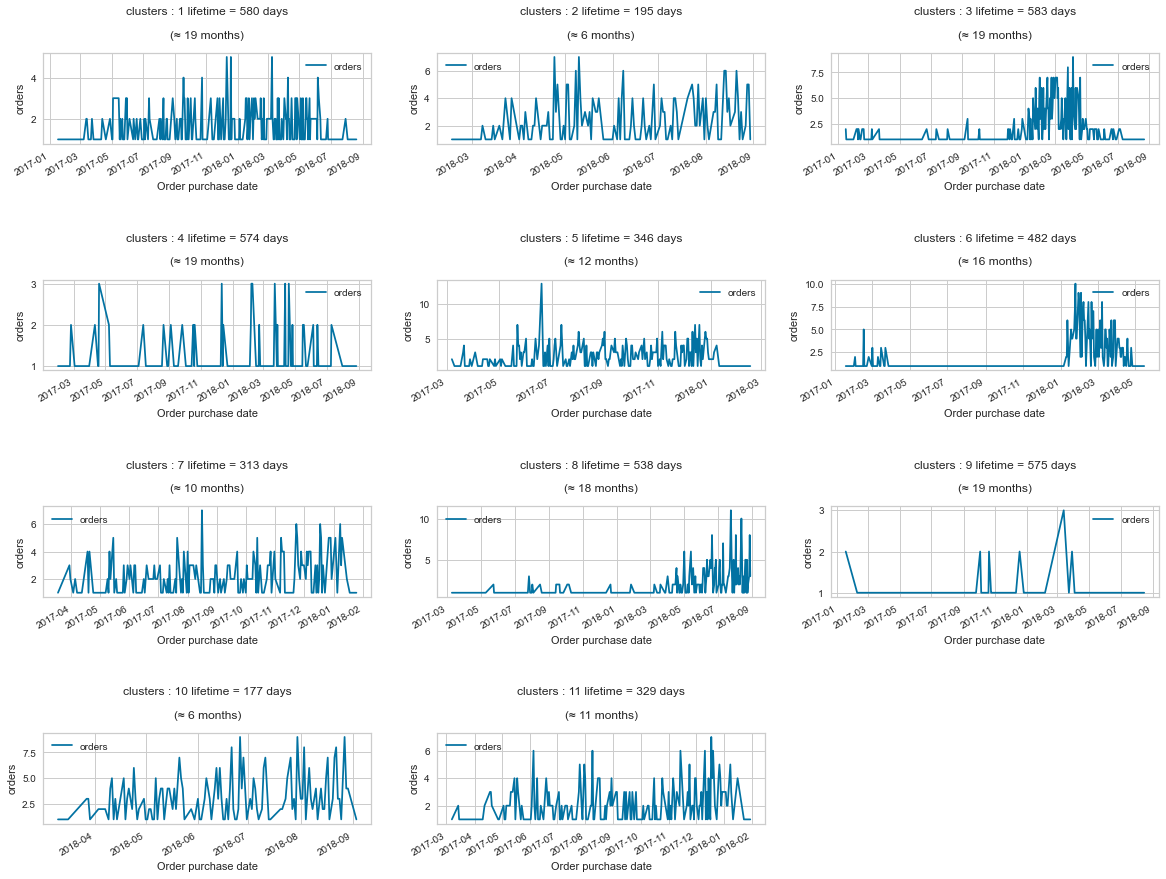

In [34]:
# Plot segment lifetime 

df_ts_11k = plot_time_serie_subplots(df=df_kmeans_11k,
                                     col='order_purchase_date',
                                     cats='clusters',
                                     shape=(total_clusters_by_col_11_segments, 3),
                                     fig_size=(20, 25),
                                     xlabel='order_purchase_date'.replace('_', ' ').capitalize(),
                                     ylabel='orders',
                                     return_data=True) # 10, 20

In [35]:
# Display segment lifetime data

# Build segmentation maintenance data
df_ts_11k_lifetime_reindexed = df_ts_11k[['clusters', 'lifetime']].drop_duplicates().set_index('clusters')
segmentation_11k_update = np.round(df_ts_11k_lifetime_reindexed / 30).astype(int)
segmentation_11k_update.rename(columns={'lifetime': 'Lifetime (months)'}, inplace=True)
segmentation_11k_update.index.rename('Segments', inplace=True)
segmentation_11k_update.index = df_11_segments_colored.index
segmentation_11k_update.T

,1 - Best Customers,2 - Cheap New Customers,3 - Promising Customers,4 - Highest Paying Customers,5 - Promising Customers Lost,6 - Cheap Customers,7 - Impulse Customers Lost,8 - Best New Customers,9 - Loyal Customers,10 - Impulse New Customers,11 - Cheap Customers Lost
Lifetime (months),19,6,19,19,12,16,10,18,19,6,11


In [36]:
# Segments in red must be updated first, unlike those in green
segmentation_11k_update_colored = segmentation_11k_update.style.apply(highlight_segment_update, axis=None)
segmentation_11k_update_colored

,Lifetime (months)
1 - Best Customers,19
2 - Cheap New Customers,6
3 - Promising Customers,19
4 - Highest Paying Customers,19
5 - Promising Customers Lost,12
6 - Cheap Customers,16
7 - Impulse Customers Lost,10
8 - Best New Customers,18
9 - Loyal Customers,19
10 - Impulse New Customers,6


In [37]:
# Save model as pkl
pickle_data(filename='Multiple_orders_kmeans_11k',
            data=kmeans_best_model_11k,
            folder='../data/pkl',
            method='w')

In [38]:
# Extract segment labels from segmentation dataframes (k = 6)
segment_labels_6k = [x.split('-')[1].strip() for x in df_6_segments_colored.index.tolist()]
# Extract segment labels from segmentation dataframes (k = 11)
segment_labels_11k = [x.split('-')[1].strip() for x in df_11_segments_colored.index.tolist()]
# Segments specific to k = 6 segmentation
segment_specifics_to_6k = [segment for segment in segment_labels_6k if segment not in segment_labels_11k]
print('Segments specific to k = 6 segmentation : {}\n'.format(segment_specifics_to_6k))
# Segments specific to k = 11 segmentation
segment_specifics_to_11k = [segment for segment in segment_labels_11k if segment not in segment_labels_6k]
print('Segments specific to k = 11 segmentation :')
segment_specifics_to_11k

Segments specific to k = 6 segmentation : ['Promising New Customers', 'New Customers']

Segments specific to k = 11 segmentation :


['Cheap New Customers',
 'Promising Customers',
 'Highest Paying Customers',
 'Cheap Customers',
 'Best New Customers',
 'Loyal Customers',
 'Impulse New Customers']

In [39]:
# Build selected segmentation mapping dictionary
segmentation_selected = {n+1: segment for n, segment in enumerate(segment_labels_11k)}

# Save best segmentation as pkl
pickle_data(filename='Multiple_orders_11k_segmentation_dict',
            data=segmentation_selected,
            folder='../data/pkl',
            method='w')

# III - Results <a class="anchor" id="third"></a>

**Selected model :**
 - k-means with **k = 11**
 
**Evaluations :**
 - Validation set **(algorithm generalization)**
 - Feature importance **(training & data acquisition costs)**
 - Segment analysis **(qualify customers)**

## 1 - Generalization <a class="anchor" id="third_1"></a>

In [40]:
# Import validation set
validation_set = pd.read_csv('../data/csv/olist_validation_set.csv')
#validation_set = validation_set_raw.drop_duplicates(subset='customer_id')
# Log scaling 
validation_set_subset = np.log1p(validation_set[features_std_scaled.columns.tolist()])
# Standard scaler
validation_set_subset_std = pd.DataFrame(std_scaler.transform(validation_set_subset),
                                         columns=validation_set_subset.columns)
# Select best feature selection
# best_features_6k = ['recency', 'frequency', 'monetary_value', 'total_products_purchased']
validation_set_subset_std_best_features = validation_set_subset_std[best_features_11k]
# Predict 
validation_set_clusters = kmeans_best_model_11k.model.predict(validation_set_subset_std_best_features)
# Compute silhouette score
validation_set_silhouette_score = round(silhouette_score(validation_set_subset_std_best_features.values,
                                                         validation_set_clusters), 2)
# Display silhouette score
print(f'Validation set silhouette score : {validation_set_silhouette_score}')
# Correction of cluster indexing
validation_set_clusters += 1
# Assign cluster labels
validation_set['clusters'] = validation_set_clusters
# Get centroid features
centroid_features = features_std_scaled.columns.tolist()+['clusters']
# Centroids inspection
validation_set_centroids = validation_set[centroid_features].groupby('clusters').mean().T
validation_set_medians = validation_set[centroid_features].groupby('clusters').median().T
validation_set_centroids

Validation set silhouette score : 0.31


clusters,1,2,3,4,5,6,7,8,9,10,11
recency,273.795281,128.192730,238.694981,286.624886,396.481315,291.917155,392.275400,101.181204,248.567430,117.364089,401.182544
frequency,1.956280,1.000000,1.869277,1.000260,1.718595,1.000000,1.000000,1.798526,3.951654,1.000000,1.000000
monetary_value,514.068432,49.907200,153.413618,595.975867,149.006385,96.462700,158.463543,189.687801,469.549288,159.818953,54.574472
total_products_purchased,2.272033,1.025355,2.198014,1.045946,2.226925,1.019202,1.026103,2.194717,6.508906,1.020783,1.025481
total_sellers,2.149202,1.018320,2.157198,1.016790,2.149482,1.005314,1.005624,2.141278,5.951654,1.000756,1.017068
main_order_purchase_month,4.343511,5.564708,2.005516,5.244696,7.862674,1.904716,8.692933,5.665848,5.356234,5.861821,8.444740
main_order_purchase_day,11.761277,15.032244,12.838389,15.214760,14.217019,15.520802,15.954518,12.120393,11.384224,14.886888,16.216923
average_price,234.368341,35.388869,67.055317,549.736727,70.954088,78.378824,135.532866,87.172353,103.294835,134.155261,39.781186
average_freight_value,27.114504,14.354752,16.609459,39.255495,16.846574,17.386756,21.451445,19.910596,19.462112,24.107528,14.592531
average_payment_value,268.659896,49.907200,84.574120,594.990363,89.517371,96.462700,158.463543,108.752555,131.670611,159.818953,54.574472


In [41]:
# Centroid deviations from validation & training sets
centroid_deviations = percentage_change(validation_set_centroids, training_set_11k_centroids, precision=0)
centroid_average_deviations = centroid_deviations.mean().to_frame(name='Average deviations (%)').T
centroid_average_deviations

clusters,1,2,3,4,5,6,7,8,9,10,11
Average deviations (%),-0.8,-0.1,-1.0,-1.2,0.1,-0.7,1.3,-1.8,-3.4,0.6,-0.3


In [42]:
# Global centroid deviation mean
centroid_average_deviations.mean(axis=1).to_frame(name='Global mean')

,Global mean
Average deviations (%),-0.663636


Regarding the generalization of our algorithm, the average deviation of the observed centroids is **at most 3%** which is affordable here.

In [43]:
# Median deviations from validation & training sets
median_deviations = percentage_change(validation_set_medians, training_set_11k_medians, precision=0)
median_average_deviations = median_deviations.mean().to_frame(name='Average deviations (%)').T
median_average_deviations

clusters,1,2,3,4,5,6,7,8,9,10,11
Average deviations (%),-0.5,-1.6,-1.5,-3.3,-0.9,0.3,1.1,-1.8,-5.6,0.5,-0.4


In [44]:
# Global median deviation mean
median_average_deviations.mean(axis=1).to_frame(name='Global mean')

,Global mean
Average deviations (%),-1.245455


## 2 - Feature importance <a class="anchor" id="third_2"></a>

#### Get feature importance from supervised learning (Classification) :
**Train 3 classifiers :**
- **XGBoost**
- **Random Forest**
- **SVM multiclass**

### 2.1 - Split training & testing sets

In [45]:
# Create training set copy from k-means (k = 11) dataframe
df_km = df_kmeans_11k.copy()

# Delete customer_id index
df_km.reset_index(drop=True,
                  inplace=True)

# Features data
X = df_km.iloc[:, ~df_km.columns.isin(['clusters',
                                       'segment',
                                       'order_purchase_date'])]

# Extract features labels
training_features = X.columns.tolist()

# Targets data (cluster labels)
y = df_km.iloc[:, df_km.columns == 'clusters'].values.ravel()

# Training & testing sets split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

### 2.2 - Feature Scaling

In [46]:
# Standardize data (center & reduce)

# Training set (and standard scaler instance)
X_train_std, std_scaler = standard_scaler(X_train,
                                          return_std_scaler=True)
# Testing set
X_test_std = std_scaler.transform(X_test)

# Build dataframes from standardized training & testing data
# => this makes it easier to filter the features that contribute the most to the model

# Training set dataframe
X_train_std_df = pd.DataFrame(X_train_std,
                              columns=training_features)
# Testing set dataframe
X_test_std_df = pd.DataFrame(X_test_std,
                             columns=training_features)

# Build training & testing data dictionary
training_data = {"train": [X_train_std_df,
                           y_train],
                 
                 "test": [X_test_std_df,
                          y_test]}

### 2.3 - Train XGBoost

In [47]:
%%time

# XGBoost classifier model
xgb_cls = xgb.XGBClassifier(objective='multi:softmax')

# XGBoost classifier parameter grid (with pre-selected optimal parameters)
xgb_cls_params = {'n_estimators': [200],
                  #'alpha': [0.5], # np.arange(1, 2, 0.1),
                  #'lambda': [10],
                  'learning_rate': [0.5], 
                  #'max_depth': [20],
                  'colsample_bytree': [0.35]}

# Train XGBoost classifier with GridSearchCV
xgb_cls_data = train_gridsearch(training_data,
                                xgb_cls,
                                xgb_cls_params,
                                'accuracy')

XGBClassifier
--------------------------
Testing set performances :
- ACCURACY = 0.963
--------------------------------
Training set performances (CV) :
- ACCURACY = 0.961
CPU times: user 51.5 s, sys: 642 ms, total: 52.2 s
Wall time: 15.6 s


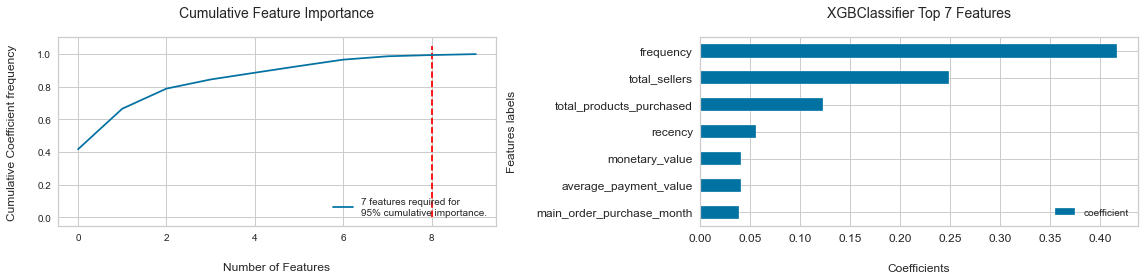

In [48]:
# Get feature importance (threshold = 95%)

# Get XGBoost classifier trained model
xgb_cls_model = xgb_cls_data['model']

# Get XGBoost classifier feature coefficients
xgb_cls_coefs = xgb_cls_model.feature_importances_

# XGBoost classifier feature coefficients dataframe
xgb_cls_features_coefs_df = get_features_importance(training_features,
                                                    xgb_cls_coefs,
                                                    abs_coefs=True,
                                                    non_zero_coefs=False,
                                                    verbose=False)
# Add model name as index label
xgb_cls_features_coefs_df.index.name = model_name(xgb_cls_model)

# Plot cumulative feature importance
xgb_cls_n_best_features_df = subplot_feature_importance(xgb_cls_features_coefs_df,
                                                        threshold=0.95,
                                                        plot_size=(16, 4), # 15, 5
                                                        return_data=True)

### 2.4 - Train Random Forest

In [49]:
%%time 

# Random Forest classifier model
rf_cls_model = RandomForestClassifier(random_state=42)


# Random Forest classifier parameter grid (with pre-selected optimal parameters)
rf_cls_params = {'n_estimators': [200],
                 #'max_depth': [40],
                 #'max_features': ['auto', 'sqrt', 'log2']
                 'min_samples_leaf': [1]}

# Train Random Forest classifier with GridSearchCV
rf_cls_data = train_gridsearch(training_data,
                               rf_cls_model,
                               rf_cls_params,
                               'accuracy')

RandomForestClassifier
--------------------------
Testing set performances :
- ACCURACY = 0.967
--------------------------------
Training set performances (CV) :
- ACCURACY = 0.965
CPU times: user 11.1 s, sys: 18.5 ms, total: 11.1 s
Wall time: 11.1 s


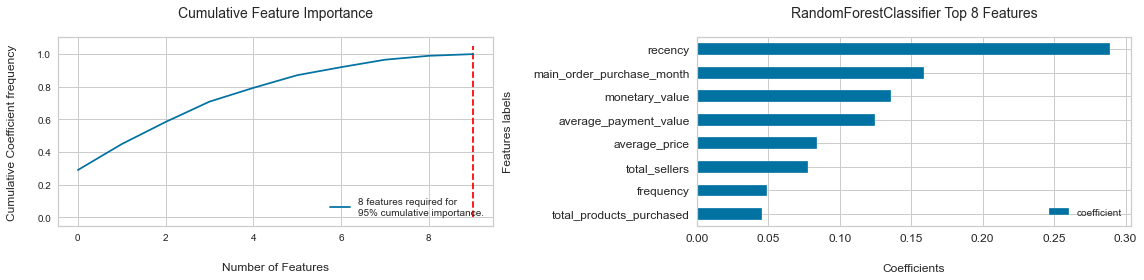

In [50]:
# Get feature importance (threshold = 95%)

# Get Random Forest classifier trained model
rf_cls_model = rf_cls_data['model']

# Get Random Forest classifier feature coefficients
rf_cls_coefs = rf_cls_model.feature_importances_

# Random Forest classifier feature coefficients dataframe
rf_cls_features_coefs_df = get_features_importance(training_features,
                                                    rf_cls_coefs,
                                                    abs_coefs=True,
                                                    non_zero_coefs=False,
                                                    verbose=False)
# Add model name as index label
rf_cls_features_coefs_df.index.name = model_name(rf_cls_model)

# Plot cumulative feature importance
rf_cls_n_best_features_df = subplot_feature_importance(rf_cls_features_coefs_df,
                                                       threshold=0.95,
                                                       plot_size=(16, 4), # 15, 5
                                                       return_data=True)

### 2.5 - Train SVM multiclass

In [51]:
%%time

# Linear SVM classifier model
linear_svm_cls_model = LinearSVC(dual=False)

# Linear SVM classifier parameter grid (with pre-selected optimal parameters)
linear_svm_cls_params = {'C': [1]}

# Train Linear SVM classifier with GridSearchCV
linear_svm_cls_data = train_gridsearch(training_data,
                                       linear_svm_cls_model,
                                       linear_svm_cls_params,
                                       'accuracy')

LinearSVC
--------------------------
Testing set performances :
- ACCURACY = 0.923
--------------------------------
Training set performances (CV) :
- ACCURACY = 0.928
CPU times: user 582 ms, sys: 8.12 ms, total: 590 ms
Wall time: 591 ms


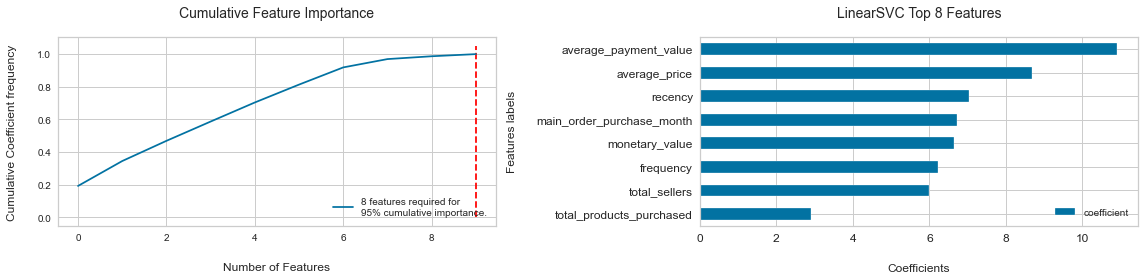

In [52]:
# Get feature importance (threshold = 95%)

# Get Linear SVM classifier trained model
linear_svm_cls_model = linear_svm_cls_data['model']

# Get Linear SVM classifier feature coefficients
linear_svm_cls_coefs = [sum(np.abs(x)) for x in linear_svm_cls_model.coef_.T] 

# Linear SVM classifier feature coefficients dataframe
linear_svm_cls_features_coefs_df = get_features_importance(training_features,
                                                           linear_svm_cls_coefs,
                                                           abs_coefs=True,
                                                           non_zero_coefs=False,
                                                           verbose=False)
# Add model name as index label
linear_svm_cls_features_coefs_df.index.name = model_name(linear_svm_cls_model)

# Plot cumulative feature importance
linear_svm_cls_n_best_features_df = subplot_feature_importance(linear_svm_cls_features_coefs_df,
                                                               threshold=0.95,
                                                               plot_size=(16, 4), # 15, 5
                                                               return_data=True)

In [53]:
# Analyse most important features for each classifier

# All classifiers feature coefficients dataframes
cls_results = {'xgBoost': xgb_cls_n_best_features_df, 
               'Random Forest': rf_cls_n_best_features_df,
               'Linear SVM': linear_svm_cls_n_best_features_df}

# Get n first features cumulative importance for each classifier
fimp_res = pd.concat([feature_importance_ratio(results_df, model_label, n=3) 
                      for model_label, results_df in cls_results.items()])
fimp_res

,3 most important features,model,coefficient ratio (%)
0,"[frequency, total_sellers, total_products_purchased]",xgBoost,81.61
0,"[recency, main_order_purchase_month, monetary_value]",Random Forest,60.49
0,"[average_payment_value, average_price, recency]",Linear SVM,48.31


**Features that contribute the most to the model :**
 - **RFM main features** (recency, frequency, monetary value)
 - **total sellers** (correlated to frequency)
 - **total products purchased** (correlated to frequency)
 - **order purchase month**
 
**Secondary features :**
 - **average payment value**
 - **average price**

## 3 - Segment analysis <a class="anchor" id="third_3"></a>

### 3.1 - Prepare dataset

In [54]:
# Rename original segment variable as RFM segments
validation_set.rename(columns={'segment': 'RFM segments'}, inplace=True)
# Map segment labels to original dataset
validation_set['k-means segments'] = validation_set['clusters'].map(segmentation_selected)

### 3.2 - Segment overview

In [55]:
# RFM segments
rfm_segments = validation_set['RFM segments'].unique().tolist()
rfm_segments

['New customers',
 'Churned customers',
 'Rising customers',
 'About to churn',
 'Loyal customers',
 'Best customers',
 'Former best customers']

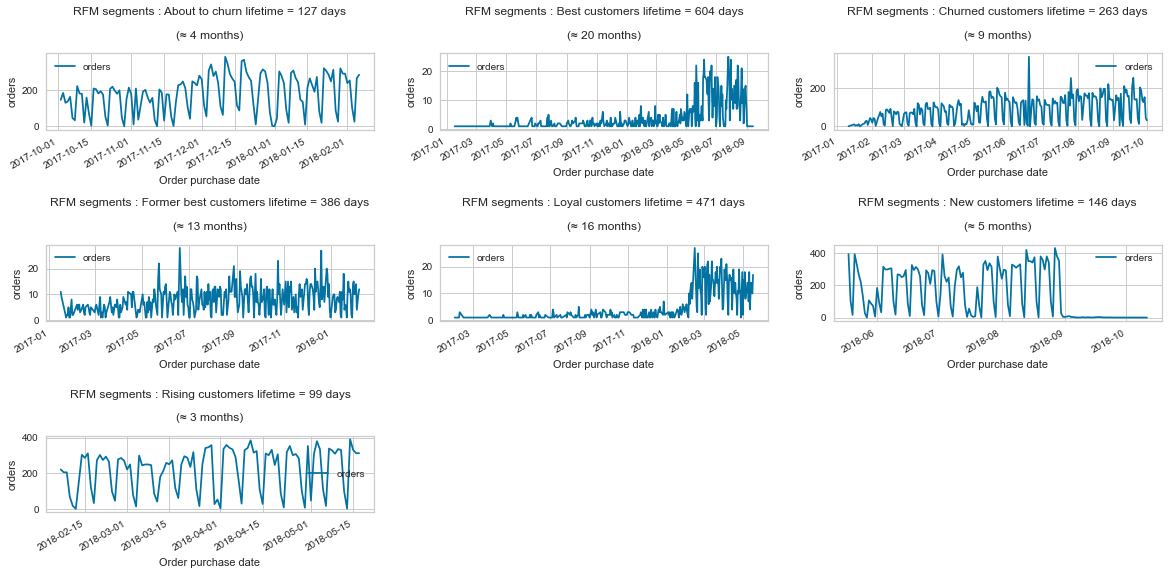

In [56]:
# Plot RFM segment lifetime (from validation set)

plot_time_serie_subplots(df=validation_set,
                         col='order_purchase_date',
                         cats='RFM segments',
                         shape=(len(rfm_segments), 3),
                         fig_size=(20, 25),
                         xlabel='order_purchase_date'.replace('_', ' ').capitalize(),
                         ylabel='orders',
                         return_data=False)

In [57]:
# k-means segments
kmeans_segments = validation_set['k-means segments'].unique().tolist()
kmeans_segments

['Impulse New Customers',
 'Cheap Customers Lost',
 'Cheap New Customers',
 'Highest Paying Customers',
 'Cheap Customers',
 'Impulse Customers Lost',
 'Promising Customers',
 'Best New Customers',
 'Promising Customers Lost',
 'Best Customers',
 'Loyal Customers']

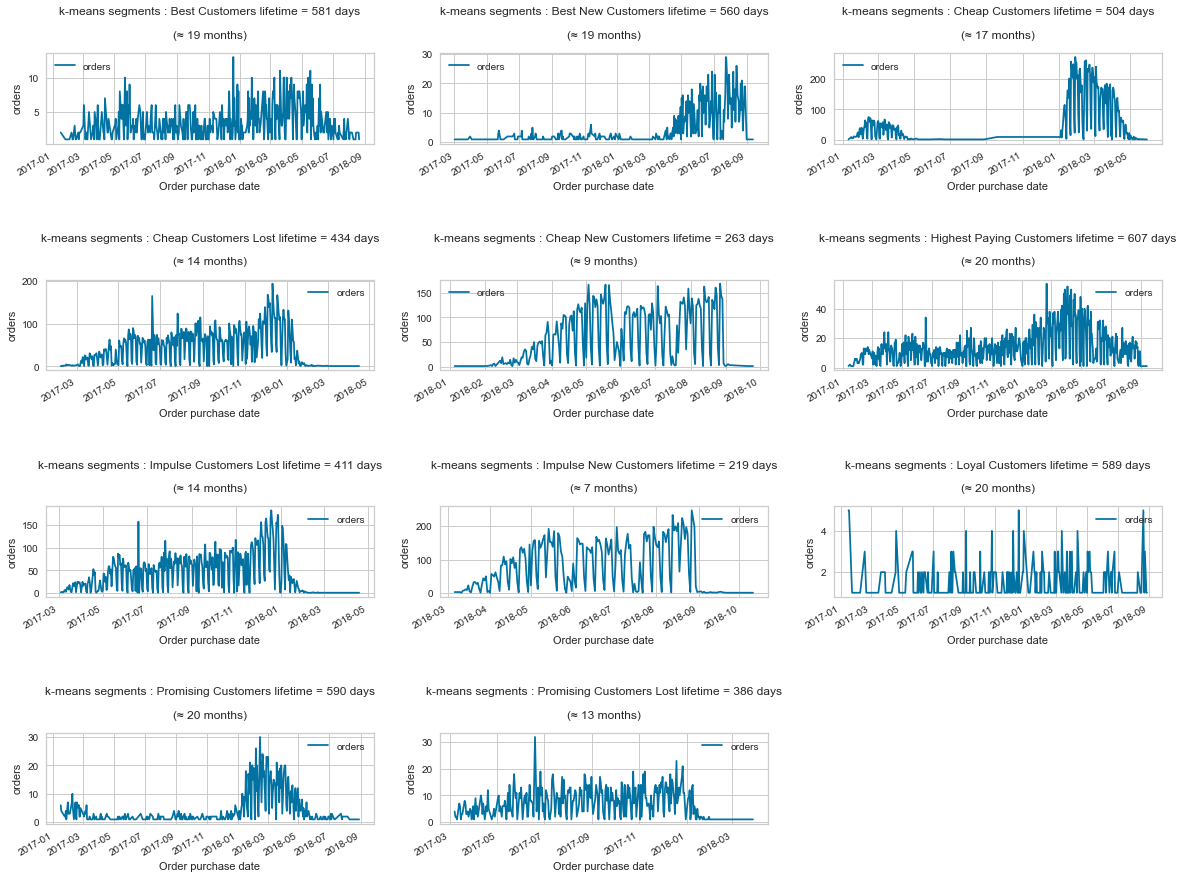

In [58]:
# Plot k-means segment lifetime (from validation set)

plot_time_serie_subplots(df=validation_set,
                         col='order_purchase_date',
                         cats='k-means segments',
                         shape=(total_clusters_by_col_11_segments, 3),
                         fig_size=(20, 25),
                         xlabel='order_purchase_date'.replace('_', ' ').capitalize(),
                         ylabel='orders',
                         return_data=False)

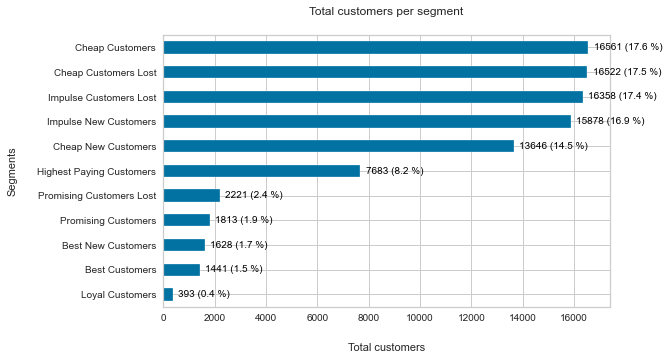

In [59]:
# Total customers per segment title
total_customers_title = 'Total customers per segment'
# Total customers per segment data
total_customers_data = validation_set.groupby(['k-means segments'])['k-means segments'].count().sort_values()
# Plot figure
total_customers_ax = total_customers_data.plot(kind='barh', figsize=(8, 5))
# Add title & axis labels
total_customers_ax.set_title(total_customers_title, pad=20)
total_customers_ax.set_xlabel("Total customers", labelpad=20)
total_customers_ax.set_ylabel("Segments", labelpad=20)
# Add total customers values
for i, total_customers in enumerate(total_customers_data):
    total_customers_proportion = round((total_customers / total_customers_data.sum())*100, 1)
    total_customers_ax.text(total_customers + 200, i - 0.1,
                            str(total_customers) + f' ({total_customers_proportion} %)',
                            color='black')
plt.show()

### 3.3 - Product analysis 

In [60]:
# The most frequently purchased product by segment
validation_set.groupby('k-means segments')['product_category_name_en'].agg(lambda x: pd.Series.mode(x)[0])

k-means segments
Best Customers              bed_bath_table
Best New Customers          bed_bath_table
Cheap Customers             bed_bath_table
Cheap Customers Lost        sports_leisure
Cheap New Customers          health_beauty
Highest Paying Customers     health_beauty
Impulse Customers Lost      bed_bath_table
Impulse New Customers        health_beauty
Loyal Customers             bed_bath_table
Promising Customers         bed_bath_table
Promising Customers Lost    bed_bath_table
Name: product_category_name_en, dtype: object

In [61]:
# The most frequently purchased recurring product by segment
validation_set.groupby('k-means segments')['most_recurring_product_purchased'].agg(lambda x: pd.Series.mode(x)[0])

k-means segments
Best Customers                   cama_mesa_banho
Best New Customers               cama_mesa_banho
Cheap Customers             no_recurring_product
Cheap Customers Lost        no_recurring_product
Cheap New Customers         no_recurring_product
Highest Paying Customers    no_recurring_product
Impulse Customers Lost      no_recurring_product
Impulse New Customers       no_recurring_product
Loyal Customers                  cama_mesa_banho
Promising Customers              cama_mesa_banho
Promising Customers Lost         cama_mesa_banho
Name: most_recurring_product_purchased, dtype: object

In [62]:
# English translation of the most frequently purchased recurring product 
validation_set[validation_set.product_category_name == 'cama_mesa_banho']['product_category_name_en'].iloc[0]

'bed_bath_table'

In [63]:
# Product photos quantity median by segment
validation_set.groupby('k-means segments')['product_photos_qty'].median()

k-means segments
Best Customers              1.0
Best New Customers          1.0
Cheap Customers             1.0
Cheap Customers Lost        2.0
Cheap New Customers         1.0
Highest Paying Customers    2.0
Impulse Customers Lost      1.0
Impulse New Customers       1.0
Loyal Customers             2.0
Promising Customers         1.0
Promising Customers Lost    2.0
Name: product_photos_qty, dtype: float64

In [64]:
# Product weight (g) mean by segment
validation_set.groupby('k-means segments')['product_weight_g'].mean()

k-means segments
Best Customers              4056.796669
Best New Customers          1759.714988
Cheap Customers             1641.011352
Cheap Customers Lost         798.614090
Cheap New Customers          631.714861
Highest Paying Customers    6097.747234
Impulse Customers Lost      2917.335065
Impulse New Customers       2476.554856
Loyal Customers             2074.577608
Promising Customers         1404.131826
Promising Customers Lost    1532.453850
Name: product_weight_g, dtype: float64

### 3.4 - Buying behavior

#### 3.4.1 - All segments

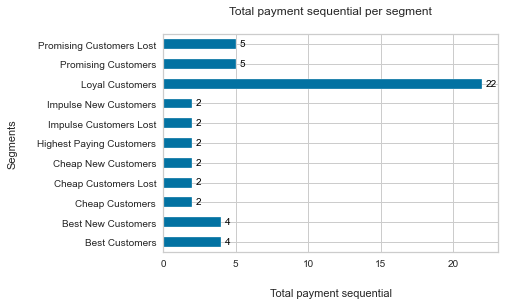

In [65]:
# Total payment sequential upper bound per segment

# Total payment sequential upper bound title
total_payment_sequential_title = 'Total payment sequential per segment'
# Total payment sequential upper data
total_payment_sequential_data = validation_set.groupby('k-means segments')['total_payment_sequential'].max()
# Plot figure
total_pay_seq_ax = total_payment_sequential_data.plot(kind='barh')
# Add title & axis labels
total_pay_seq_ax.set_title(total_payment_sequential_title, pad=20)
total_pay_seq_ax.set_xlabel("Total payment sequential", labelpad=20)
total_pay_seq_ax.set_ylabel("Segments", labelpad=20)
# Add total payment sequential upper bound values
for i, v in enumerate(total_payment_sequential_data):
    total_pay_seq_ax.text(v + 0.25, i - 0.1, str(v), color='black')
plt.show()

In [66]:
# The most frequently order purchase hour by segment
validation_set.groupby('k-means segments')['order_purchase_hour'].agg(lambda x: pd.Series.mode(x)[0])

k-means segments
Best Customers              17
Best New Customers          16
Cheap Customers             14
Cheap Customers Lost        13
Cheap New Customers         16
Highest Paying Customers    14
Impulse Customers Lost      16
Impulse New Customers       16
Loyal Customers             14
Promising Customers         15
Promising Customers Lost    13
Name: order_purchase_hour, dtype: int64

In [67]:
# The most frequently order purchase day by segment
validation_set.groupby('k-means segments')['order_purchase_day'].agg(lambda x: pd.Series.mode(x)[0])

k-means segments
Best Customers               4
Best New Customers          18
Cheap Customers             22
Cheap Customers Lost        24
Cheap New Customers         16
Highest Paying Customers     4
Impulse Customers Lost      24
Impulse New Customers       16
Loyal Customers              5
Promising Customers          5
Promising Customers Lost    24
Name: order_purchase_day, dtype: int64

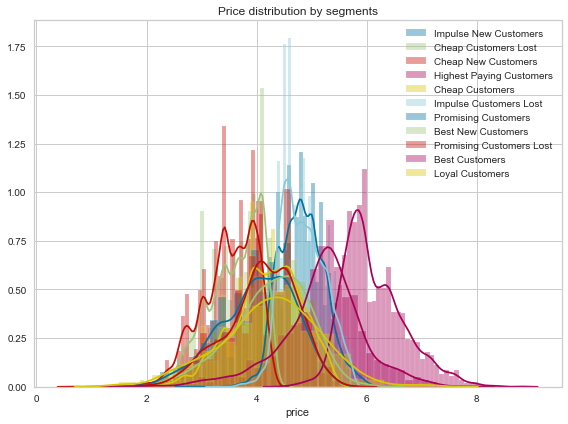

In [68]:
# Log scaled price distribution by segment
cols_to_logscale = ['payment_value', 'price', 'freight_value']
validation_set_buying_behavior = np.log1p(validation_set[cols_to_logscale].copy())
validation_set_buying_behavior['segments'] = validation_set['k-means segments']
plot_hist_by_cat(validation_set_buying_behavior,
                 'price',
                 'segments',
                 legend_size=10,
                 legend_loc='upper right')

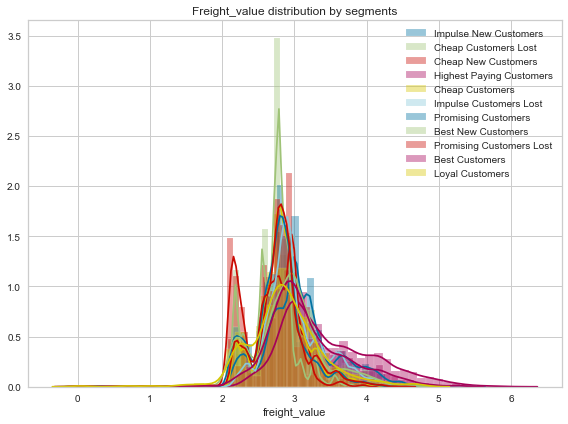

In [69]:
# Log scaled freight value distribution by segment
plot_hist_by_cat(validation_set_buying_behavior,
                 'freight_value',
                 'segments',
                 legend_size=10,
                 legend_loc='upper right')

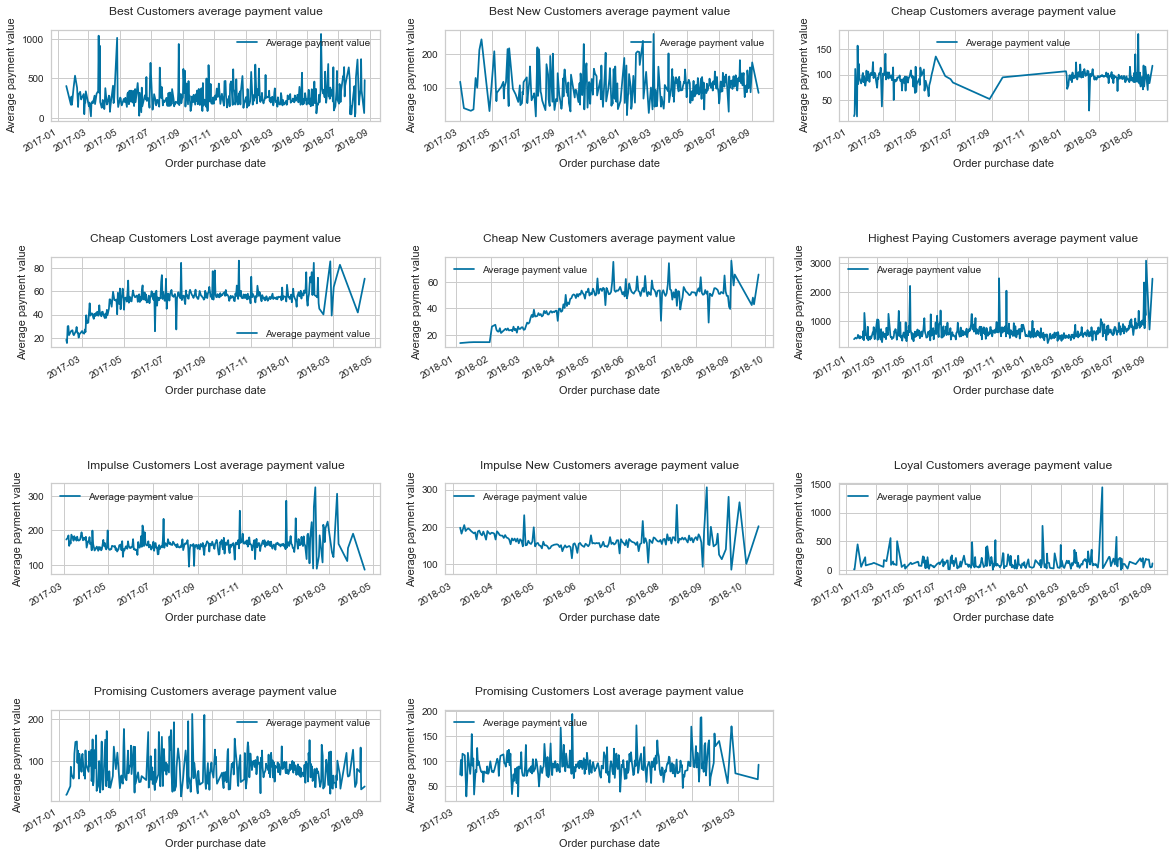

In [70]:
# Average payment value time serie by segment

avr_payment_value_time_serie_title = lambda cat: f"{cat} average payment value"

plot_time_serie_subplots(df=validation_set,
                         col='order_purchase_date',
                         cats='k-means segments',
                         shape=(total_clusters_by_col_11_segments, 3),
                         alt_col='payment_value',
                         method='mean',
                         fig_size=(20, 25),
                         xlabel='order_purchase_date'.replace('_', ' ').capitalize(),
                         ylabel='Average payment value',
                         time_serie_title=avr_payment_value_time_serie_title,
                         return_data=False)

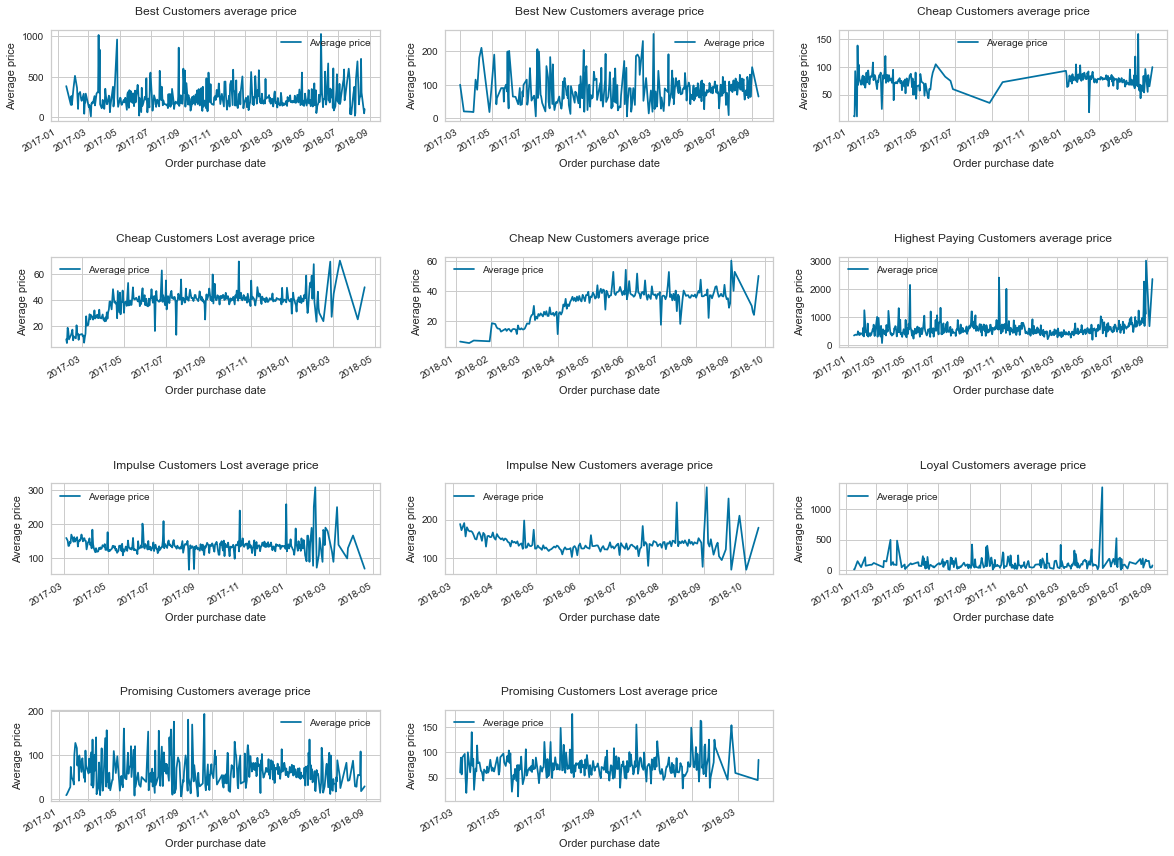

In [71]:
# Average price time serie by segment

avr_price_time_serie_title = lambda cat: f"{cat} average price"

plot_time_serie_subplots(df=validation_set,
                         col='order_purchase_date',
                         cats='k-means segments',
                         shape=(total_clusters_by_col_11_segments, 3),
                         alt_col='price',
                         method='mean',
                         fig_size=(20, 25),
                         xlabel='order_purchase_date'.replace('_', ' ').capitalize(),
                         ylabel='Average price',
                         time_serie_title=avr_price_time_serie_title,
                         return_data=False)

#### 3.4.2 - Highest Paying Customers segment

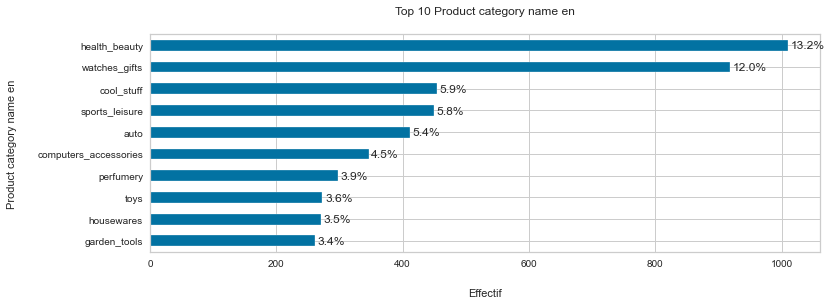

In [72]:
# The n most purchased product categories concerning Highest Paying Customers segment
plot_n_top_values(validation_set[validation_set['k-means segments'] == 'Highest Paying Customers'],
                  'product_category_name_en',
                   n=10,
                   annotation_height=1.25)

#### 3.4.3 - Promising Customers segment

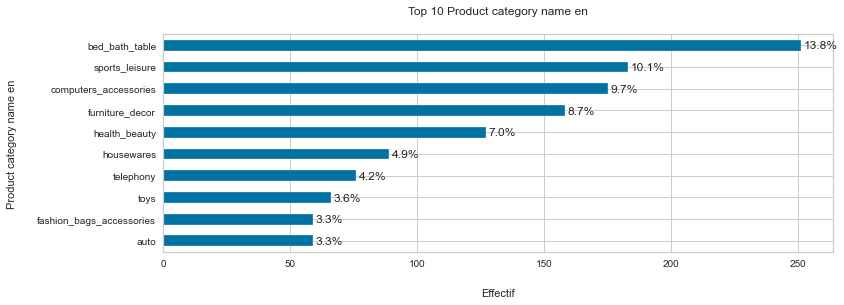

In [73]:
# The n most purchased product categories concerning Promising Customers segment
plot_n_top_values(validation_set[validation_set['k-means segments'] == 'Promising Customers'],
                  'product_category_name_en',
                   n=10,
                   annotation_height=1.25)

#### 3.4.4 - Best New Customers segment

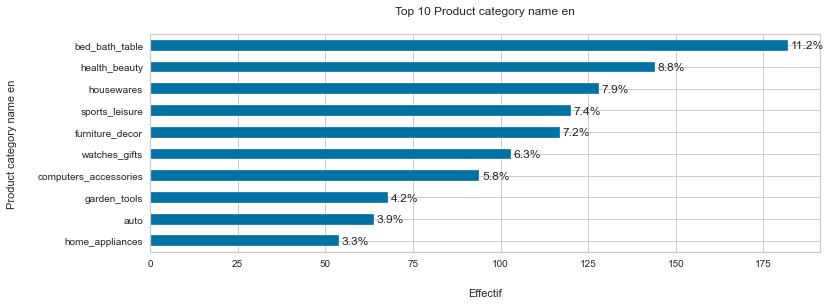

In [74]:
# The n most purchased product categories concerning Best New Customers segment
plot_n_top_values(validation_set[validation_set['k-means segments'] == 'Best New Customers'],
                  'product_category_name_en',
                   n=10,
                   annotation_height=1.25)

### 3.5 - RFM analysis

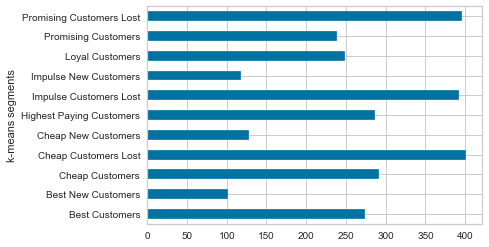

In [75]:
# Average recency by segment
validation_set.groupby('k-means segments')['recency'].mean().plot(kind='barh')
plt.show()

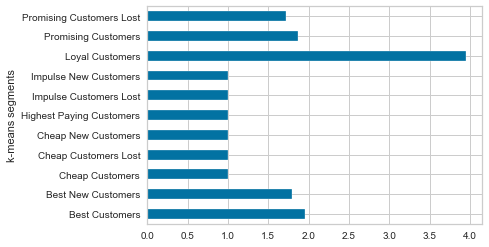

In [76]:
# Average frequency by segment
validation_set.groupby('k-means segments')['frequency'].mean().plot(kind='barh')
plt.show()

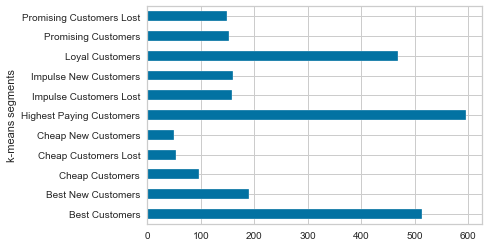

In [77]:
# Average monetary value by segment
validation_set.groupby('k-means segments')['monetary_value'].mean().plot(kind='barh')
plt.show()

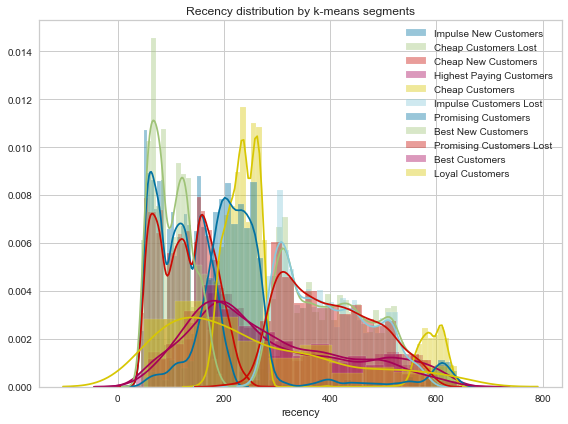

In [78]:
# Recency distribution by segment
plot_hist_by_cat(validation_set, 'recency', 'k-means segments', legend_size=10, legend_loc='upper right')

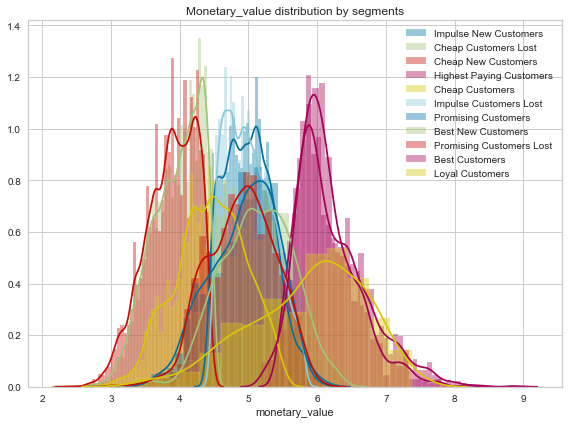

In [79]:
# Log scaled monetary value distribution by segment
validation_set_rfm_cols = validation_set[rfm_cols].copy()
validation_set_rfm_cols = np.log1p(validation_set_rfm_cols)
validation_set_rfm_cols['segments'] = validation_set['k-means segments']
plot_hist_by_cat(validation_set_rfm_cols, 'monetary_value', 'segments', legend_size=10, legend_loc='upper right')

# IV - Conclusion <a class="anchor" id="fourth"></a>

**Results obtained with RFM segmentation :**
   - **Total segments : 7**
   
   
   - **Segment labels :**
     - Rising Customers
     - Churned Customers
     - About To Churn
     - Loyal Customers
     - Former Best Customers
     - New Customers
     - Best Customers
     
     
   - **Segmentation update : every 3 months**
   
   
   - **Feature selection : 3 features**
     - Recency (customer_id, order_purchase_timestamp)
     - Frequency (customer_id, order_id)
     - Monetary value (customer_id, payment_value)
     
**Results obtained with k-means segmentation :**
   - **Total segments : 11**
   
   
   - **Segment labels :**
     - Best Customers
     - Cheap New Customers
     - Promising Customers
     - Highest Paying Customers
     - Cheap Customers
     - Promising Customers Lost
     - Impulse Customers Lost
     - Best New Customers
     - Loyal Customers
     - Impulse New Customers
     - Cheap Customers Lost
     
     
   - **Segmentation update : every 7 months**
   
   
   - **Feature selection : 7 features**
     - Recency (customer_id, order_purchase_timestamp)
     - Frequency (customer_id, order_id)
     - Monetary value (customer_id, payment_value)
     - Total product purchased (customer_id, product_id, order_item_qty)
     - Total sellers (customer_id, seller_id)
     - Main order purchase month (customer_id, order_purchase_timestamp)
     - Average payment value (customer_id, payment_value)